# Generative Adversarial Networks


In [0]:
 %tensorflow_version 1.x
 !pip install --upgrade opencv-python==3.4.2.17
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Conv2D,Activation,BatchNormalization,Conv2DTranspose, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD,RMSprop
import os
from glob import glob
from skimage.io import imread,imshow,imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import math
from keras.preprocessing import image as k_image
from keras.utils.generic_utils import Progbar
from keras.initializers import RandomNormal
import random

from google.colab import drive
drive.mount('/content/drive')


In [0]:
BATCH_SIZE = 128
IMAGE_SHAPE = [64,64]
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 2500
# Use this to prefix all your paths when reading/writing data to drive.
BASE_DIR =PATH_TO_DATASET


- Here's the link to the emojis dataset: https://drive.google.com/open?id=1WRpE9SwSqguyGrrI9EP6jlHk7f1hoJMo

- Here's the link to the full emojis dataset: https://drive.google.com/open?id=1UeIQIbixvapM-TBzngOwDXnHV_vv-MBG

In [0]:
## Helper Functions
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))
print(sample_noise().shape)
def remove_transparency(source, background_color):
    source_img = source[:, :, :3]
    source_mask = source[:, :, 3]  * (1 / 255.0)
    source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)
    background_mask = 1.0 - source_mask
    bg_part = (background_color * (1 / 255.0)) * (background_mask)
    source_part = (source_img * (1 / 255.0)) * (source_mask)
    return cv2.cvtColor(np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0)),cv2.COLOR_BGR2RGB)

def load_data():
    base_dir = '/content/drive/My Drive/Fall 2020/Deep Learning/Assignment_5/filtered_emojis/*'
    train_files = glob(base_dir)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

def create_image_grid(array, ncols=None):
    num_images, cell_h, cell_w, channels = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h*nrows, cell_w*ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w, :] = array[i*ncols+j]

    if channels == 1:
        result = result.squeeze()
    return result

In [0]:
def build_discriminator():
  random=RandomNormal(mean=0.0, stddev=0.02)
  input_15=Input(shape=(64,64,3))
  dropout1=Dropout(0.5)(input_15)
  conv2d_31=Conv2D(64,(4,4),strides=(2,2),padding="same",kernel_initializer=random,use_bias=False)(dropout1)
  leaky_re_lu_37=LeakyReLU(alpha=0.3)(conv2d_31)
  conv2d_32=Conv2D(128,(4,4),strides=(2,2),padding="same",kernel_initializer=random,use_bias=False)(leaky_re_lu_37)
  batch_normalization_31=BatchNormalization()(conv2d_32)
  leaky_re_lu_38=LeakyReLU(alpha=0.3)(batch_normalization_31)
  conv2d_33=Conv2D(256,(4,4),strides=(2,2),padding="same",kernel_initializer=random,use_bias=False)(leaky_re_lu_38)
  batch_normalization_32=BatchNormalization()(conv2d_33)
  leaky_re_lu_39=LeakyReLU(alpha=0.3)(batch_normalization_32)
  conv2d_34=Conv2D(512,(4,4),strides=(2,2),padding="same",kernel_initializer=random,use_bias=False)(leaky_re_lu_39)
  batch_normalization_33=BatchNormalization()(conv2d_34)
  leaky_re_lu_40=LeakyReLU(alpha=0.3)(batch_normalization_33)
  conv2d_35=Conv2D(1,(4,4),strides=(1,1),padding="same",kernel_initializer=random,use_bias=False)(leaky_re_lu_40)
  flatten_7=Flatten()(conv2d_35)
  dense_11=Dense(1,activation='sigmoid')(flatten_7)
  discriminator=Model(inputs=[input_15],outputs=dense_11)

  
  
  return discriminator


In [0]:
def build_gan(gen,disc):
    z=gen.input
    fake_image=gen(z)
    disc.trainable=False
    validity=disc(fake_image)
    combined_model=Model(inputs=[z],outputs=validity)
    #combined_model.summary()
    combined_model.compile(loss="binary_crossentropy", 
              optimizer=Adam(lr=0.001), 
              metrics=['accuracy'])
    return combined_model


In [0]:
def build_generator():  
    random=RandomNormal(mean=0.0, stddev=0.02)
    noise_input=Input(shape=(NOISE_DIM,))
    dense1=Dense(4*4*1024)(noise_input)
    dense1reshape=Reshape((4,4,1024))(dense1)
    convd2d_tranpose1=Conv2DTranspose(512, (5, 5), strides=(2, 2), kernel_initializer=random,padding='same',use_bias=False)(dense1reshape)
    batch_normalization_31=BatchNormalization()(convd2d_tranpose1)
    leaky_re_lu_37=LeakyReLU(alpha=0.3  )(batch_normalization_31)
    convd2d_tranpose2=Conv2DTranspose(256, (5, 5), strides=(2, 2),kernel_initializer=random, padding='same',use_bias=False)(leaky_re_lu_37)
    batch_normalization_32=BatchNormalization()(convd2d_tranpose2)
    leaky_re_lu_38=LeakyReLU(alpha=0.3)(batch_normalization_32)
    convd2d_tranpose3=Conv2DTranspose(128, (5, 5), strides=(2, 2), kernel_initializer=random,padding='same',use_bias=False)(leaky_re_lu_38)
    batch_normalization_33=BatchNormalization()(convd2d_tranpose3)
    leaky_re_lu_39=LeakyReLU(alpha=0.3)(batch_normalization_33)
    convd2d_tranpose3=Conv2DTranspose(3, (5, 5), strides=(2, 2), kernel_initializer=random,padding='same',activation='tanh',use_bias=False)(leaky_re_lu_39)


    generator=Model(inputs=[noise_input],outputs=convd2d_tranpose3)
    return generator

In [0]:

#scaling images between [-1,1]
def normalize(images):  
  normal_images= 2*(images/255)-1
  return normal_images

#For Real labels, i.e. 1s, I used smooth labels uniformly between [0.7,1.2]
def smooth_real_labels(y):
    for x in range(len(y)):
         y[x]=np.random.random()*(1.2-0.7)+0.7
    return y


#For fake labels, i.e. 0, I used smooth labels uniformly between [0,13]
def smooth_fake_labels(y):
    for x in range(len(y)):
         y[x]=np.random.random()*(0.3-0)
    return y




In [0]:
def save_samples(generated_images,step,save_at="samples1/"):
    sample_image = create_image_grid(generated_images)
    img = k_image.array_to_img(sample_image)
    img.save(os.path.join(BASE_DIR,save_at, 'generated_image_' + str(step) + '.png'))

In [0]:
def gan_training_loop(intervals=200):
    # Setup Models here
    gen=build_generator()
    discr=build_discriminator()
    discr.compile(loss="binary_crossentropy", 
              optimizer=Adam(lr=0.001), 
              metrics=['accuracy'])
    combined_model=build_gan(gen,discr)
    X_train = load_data()
    total_size = X_train.shape[0]
    
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
  
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        disc_fake_loss=[]
        disc_real_loss=[]
        
        valid = np.ones((BATCH_SIZE, 1))
        fake = np.zeros((BATCH_SIZE, 1))
      
        valid=smooth_real_labels(valid)
        fake=smooth_fake_labels(fake)   
        

        for i,index in enumerate(indices):
            # Write your code here
            noise=sample_noise()
            real_imgs=X_train[index:index+BATCH_SIZE]
            real_imgs=normalize(real_imgs)
            fake_imgs=gen.predict(noise)

            if not (e % intervals):
                save_samples1(fake_imgs,e)
            #training discriminator
            disc_real_loss=discr.train_on_batch(real_imgs,valid)
            disc_fake_loss=discr.train_on_batch(fake_imgs,fake)
            disc_loss = (disc_fake_loss[0] + disc_real_loss[0]) * 0.5
            epoch_disc_loss.append(disc_loss)
            #training gan
            gen_loss=combined_model.train_on_batch(noise,valid)
          
           
            epoch_gen_loss.append(gen_loss)
            progress_bar.update(i+1)
        if not (e%intervals):
            discr.save_weights(os.path.join(BASE_DIR,'discriminator1'),True)
            gen.save_weights(os.path.join(BASE_DIR,'generator1'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)
        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [0]:
all_disc_losses,all_gen_losses=gan_training_loop1()

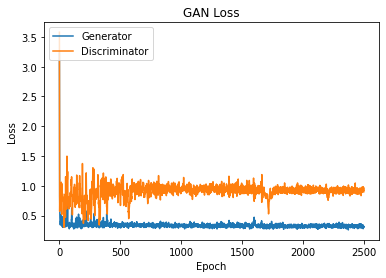

In [0]:
plot_loss(all_disc_losses,all_gen_losses)